In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from lenspack.geometry.projections import gnom 



# import matplotlib.gridspec as gridspec
# from skimage.measure import find_contours

# from astropy.io import fits
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
gt = np.load('/Users/jw/Documents/sim_00945.npy', allow_pickle=True)

In [4]:
cropped_gt = np.load('/Users/jw/Documents/cropped_sim_01416.npy', allow_pickle=True)

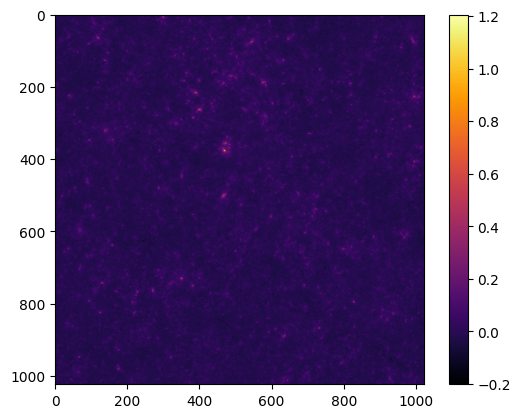

In [4]:
plt.imshow(gt, cmap='inferno')
plt.colorbar()
plt.show()

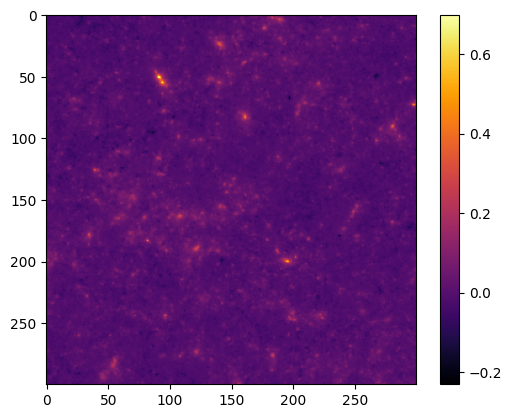

In [5]:
plt.imshow(cropped_gt, cmap='inferno')
plt.colorbar()
plt.show()

In [5]:
def compute_fourier_kernel(N: int) -> np.ndarray:
    """Computes the Fourier space kernel which represents the mapping between 
        convergence (kappa) and shear (gamma).

    Args:
        N (int): x,y dimension of image patch (assumes square images).

    Returns:
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
    """
    # Generate grid of Fourier domain
    kx = np.arange(N).astype(np.float64) - N/2
    ky, kx = np.meshgrid(kx, kx)
    k = kx**2 + ky**2
    # Define Kaiser-Squires kernel
    D = np.zeros((N, N), dtype=np.complex128)
    # D = np.where(k > 0, ((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))/k, D)
    # Another formulation to avoid divide by zero warning
    D[k>0] = (((kx ** 2.0 - ky ** 2.0) + 1j * (2.0 * kx * ky))[k>0]/k[k>0])
    # Apply inverse FFT shift 
    return np.fft.ifftshift(D)


def forward_model(kappa: np.ndarray, D: np.ndarray) -> np.ndarray:
    """Applies the forward mapping between convergence and shear through their 
        relationship in Fourier space.

    Args:
        kappa (np.ndarray): Convergence field, with shape [N,N].
        D (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].

    Returns:
        gamma (np.ndarray): Shearing field, with shape [N,N].
    """
    F_kappa = np.fft.fft2(kappa) # Perform 2D forward FFT
    F_gamma = F_kappa * D # Map convergence onto shear
    return np.fft.ifft2(F_gamma) # Perform 2D inverse FFT

In [6]:
kernel = compute_fourier_kernel(1024)
cropped_kernel = compute_fourier_kernel(300)

In [7]:
shear = forward_model(gt, kernel)
cropped_shear = forward_model(cropped_gt, cropped_kernel)

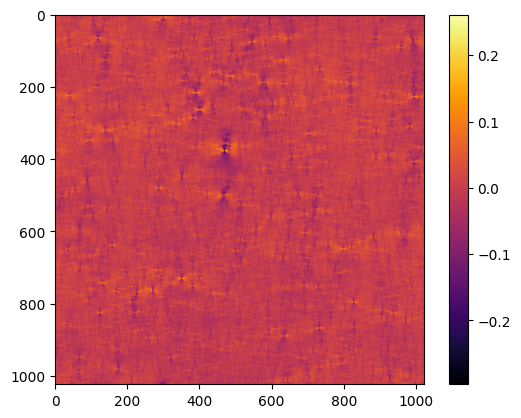

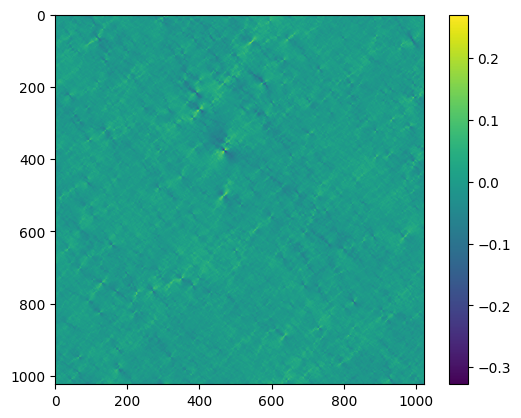

In [9]:
plt.imshow(np.real(shear), cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(shear.imag, cmap='viridis')
plt.colorbar()
plt.show()

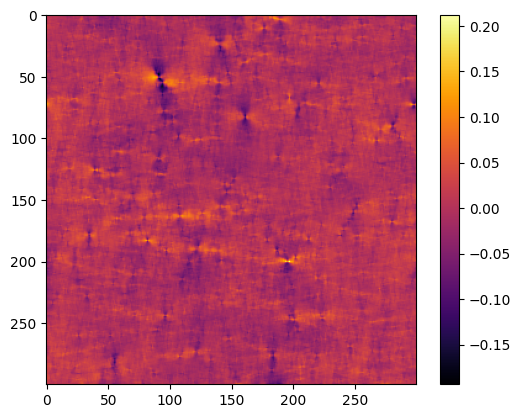

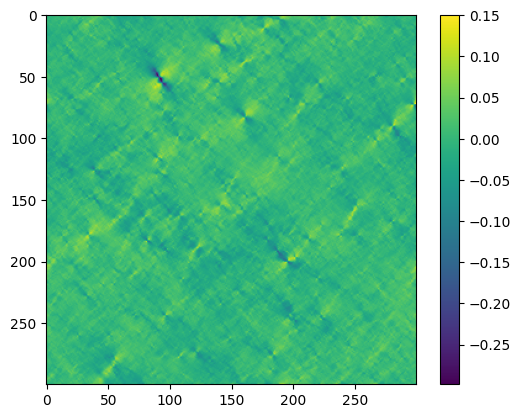

In [10]:
plt.imshow(cropped_shear.real, cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(cropped_shear.imag, cmap='viridis')
plt.colorbar()
plt.show()

In [8]:
def ks93(g1, g2):
    # Check consistency of input maps
    assert g1.shape == g2.shape

    # Compute Fourier space grids
    (nx, ny) = g1.shape
    k1, k2 = np.meshgrid(np.fft.fftfreq(ny), np.fft.fftfreq(nx))

    # Compute Fourier transforms of g1 and g2
    g1hat = np.fft.fft2(g1)
    g2hat = np.fft.fft2(g2)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[0, 0] = 1  # avoid division by 0
    kEhat = (p1 * g1hat + p2 * g2hat) / k2
    kBhat = -(p2 * g1hat - p1 * g2hat) / k2

    # Transform back to pixel space
    kE = np.fft.ifft2(kEhat).real
    kB = np.fft.ifft2(kBhat).real

    return kE, kB



def backward_model(γ: np.ndarray, 𝒟: np.ndarray) -> np.ndarray:
  """Applies the backward mapping between shear and convergence through their 
    relationship in Fourier space.
  Args:
    γ (np.ndarray): Shearing field, with shape [N,N].
    𝒟 (np.ndarray): Fourier space Kaiser-Squires kernel, with shape = [N,N].
  Returns:
    𝜅 (np.ndarray): Convergence field, with shape [N,N].
  """
  𝓕γ = np.fft.fft2(γ) # Perform 2D forward FFT
  𝓕𝜅 = 𝓕γ / 𝒟 # Map convergence onto shear
  𝓕𝜅 = np.nan_to_num(𝓕𝜅, nan=0, posinf=0, neginf=0) # Remove singularities
  return np.fft.ifft2(𝓕𝜅) # Perform 2D inverse FFT


In [9]:
kappa93 = ks93(shear.real, shear.imag)
cropped_kappa93 = ks93(cropped_shear.real, cropped_shear.imag)

In [10]:
kappa_backward = backward_model(shear, kernel)
cropped_kappa_backward = backward_model(cropped_shear, cropped_kernel)

/var/folders/6b/03s1_j_j7hxcy34z8hkmlj140000gp/T/ipykernel_25319/1148532874.py:39: RuntimeWarning: divide by zero encountered in divide
  𝓕𝜅 = 𝓕γ / 𝒟 # Map convergence onto shear


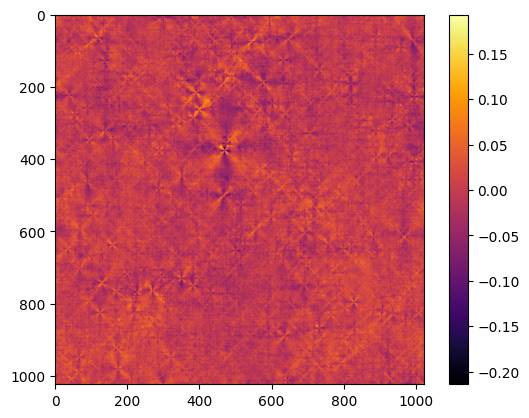

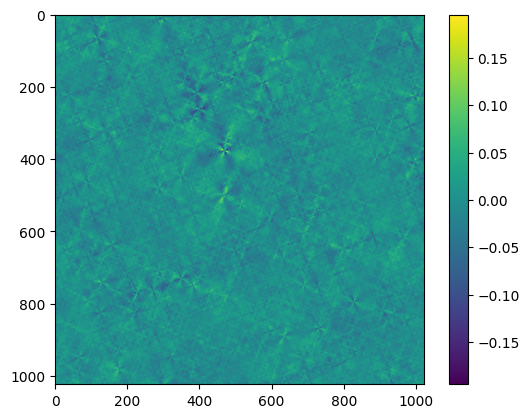

In [14]:
plt.imshow(kappa93[0], cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(kappa93[1], cmap='viridis')
plt.colorbar()
plt.show()

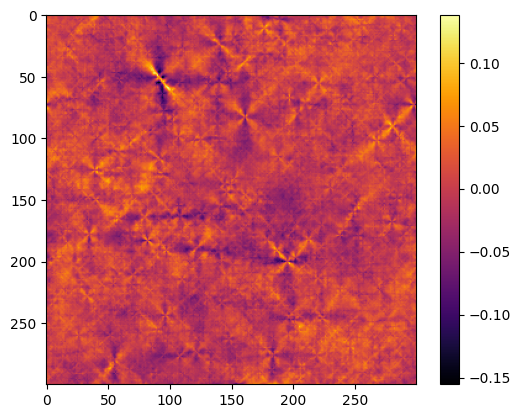

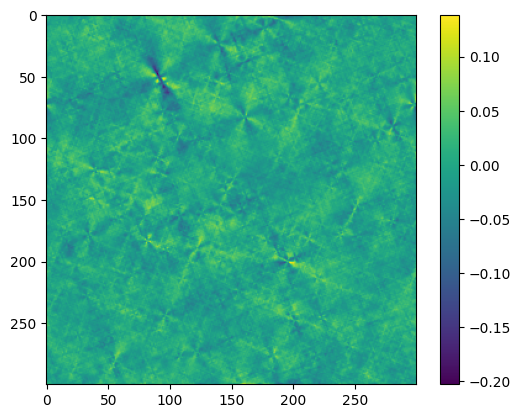

In [15]:
plt.imshow(cropped_kappa93[0], cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(cropped_kappa93[1], cmap='viridis')
plt.colorbar()
plt.show()

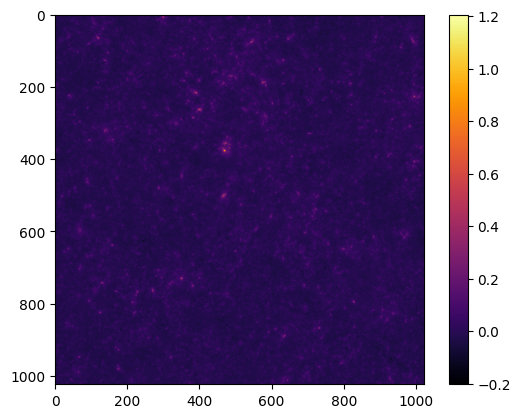

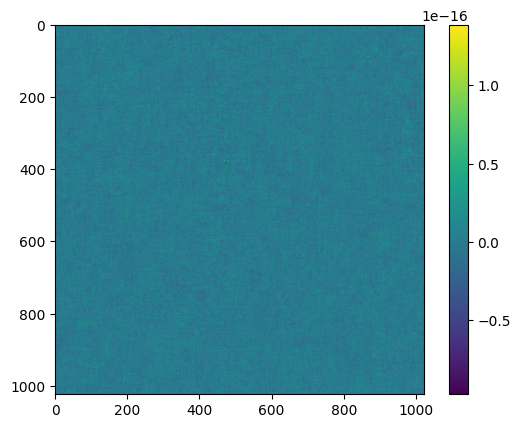

In [16]:
plt.imshow(kappa_backward.real, cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(kappa_backward.imag, cmap='viridis')
plt.colorbar()
plt.show()


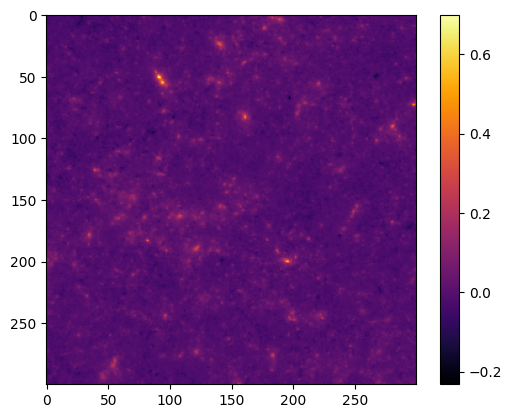

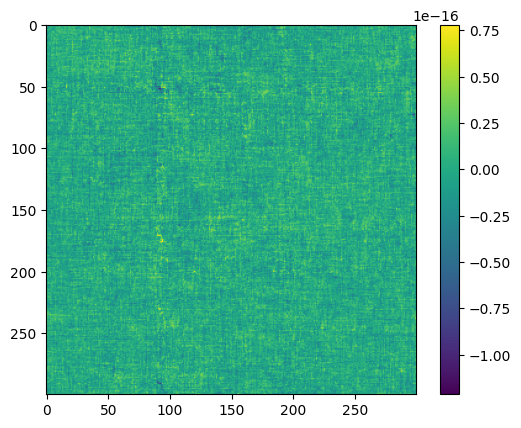

In [17]:
plt.imshow(cropped_kappa_backward.real, cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(cropped_kappa_backward.imag, cmap='viridis')
plt.colorbar()
plt.show()

It appears ks93 and the backward model are not doing the same thing - make sure I'm using the backward model in our work.

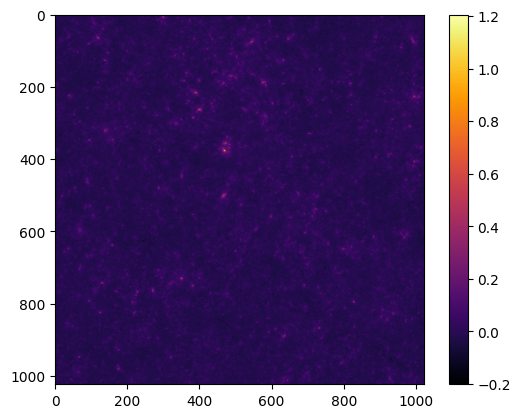

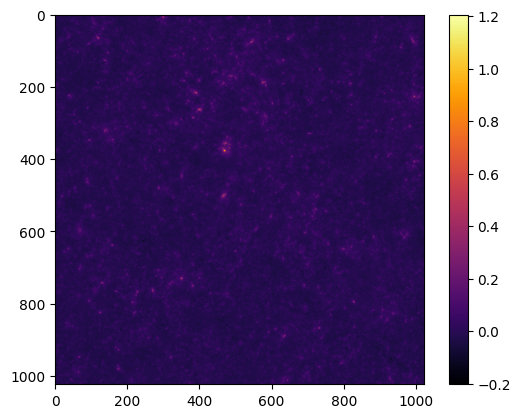

In [18]:
plt.imshow(gt, cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(kappa_backward.real, cmap='inferno')
plt.colorbar()
plt.show()

### Now let's try adding noise to the shear and seeing how that affects the backward model results.

In [11]:
#Note we are using a simpler version of the noise, for these preliminary tests.
def gamma_noise_maker(theta: float, im_size: int, kappa: np.ndarray,ngal=30) -> np.ndarray:
    """Adds some random Gaussian noise to a mock weak lensing map.

    Args:
        theta (float): Opening angle in deg.
        im_size (int): Size of weak lensing map, in pixels.
        ngal (int): Number of galaxies.
        kappa (np.ndarray): Convergence map.
    
    Returns:
        gamma (np.ndarray): A synthetic representation of the shear field, gamma, with added noise.
    """
    D = compute_fourier_kernel(im_size) #Fourier kernel
    sigma = 0.37 / np.sqrt(((theta*60/im_size)**2)*ngal)
    gamma = forward_model(kappa, D) + sigma*(np.random.randn(im_size,im_size) + 1j * np.random.randn(im_size,im_size))
    return gamma

In [12]:
noisy_shear = gamma_noise_maker(5.0, 1024, gt)
cropped_noisy_shear = gamma_noise_maker(5.0, 300, cropped_gt)

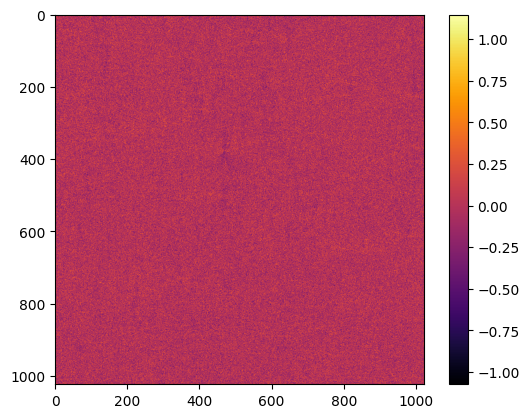

In [13]:
plt.imshow(noisy_shear.real, cmap='inferno')
plt.colorbar()
plt.show()

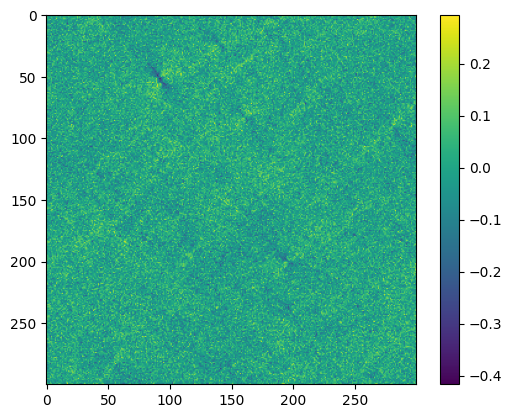

In [14]:
plt.imshow(cropped_noisy_shear.imag, cmap='viridis')
plt.colorbar()
plt.show()

In [15]:
noisy_kappa = backward_model(noisy_shear, kernel)
cropped_noisy_kappa = backward_model(cropped_noisy_shear, cropped_kernel)

/var/folders/6b/03s1_j_j7hxcy34z8hkmlj140000gp/T/ipykernel_25319/1148532874.py:39: RuntimeWarning: divide by zero encountered in divide
  𝓕𝜅 = 𝓕γ / 𝒟 # Map convergence onto shear


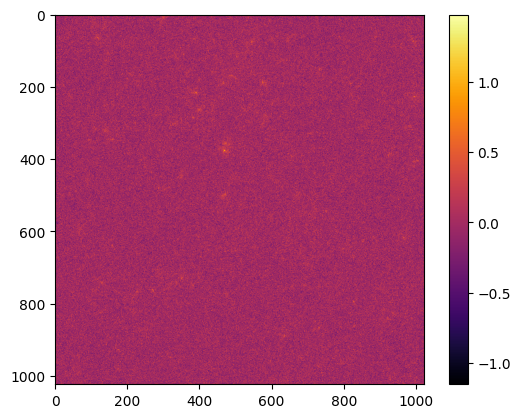

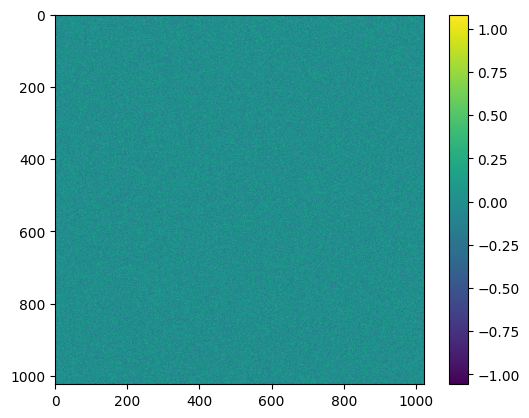

In [28]:
plt.imshow(noisy_kappa.real, cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(noisy_kappa.imag, cmap='viridis')
plt.colorbar()
plt.show()

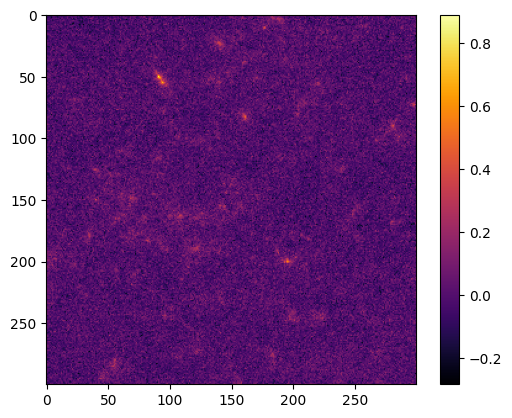

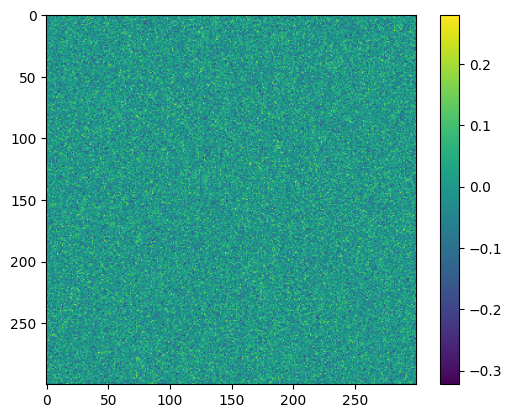

In [29]:
plt.imshow(cropped_noisy_kappa.real, cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(cropped_noisy_kappa.imag, cmap='viridis')
plt.colorbar()
plt.show()
#Results are as expected.

In [ ]:
#Now to apply Gaussian smoothing.

In [63]:
scipy_kappa = ndimage.gaussian_filter(gt, sigma=1)


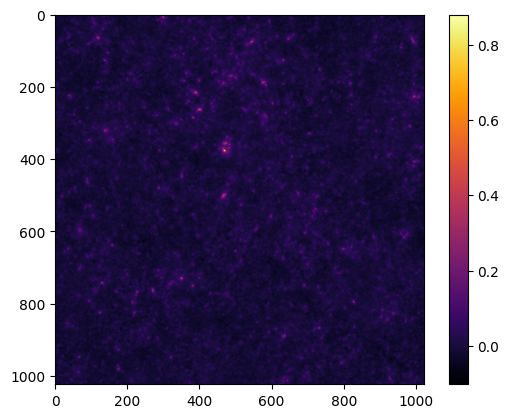

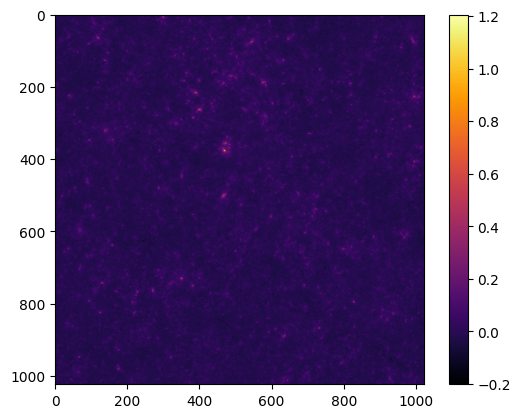

In [65]:
plt.imshow(scipy_kappa, cmap='inferno')
plt.colorbar()
plt.show()
plt.imshow(gt, cmap='inferno')
plt.colorbar()
plt.show()

In [82]:
pw_diff = np.abs(gt - scipy_kappa)

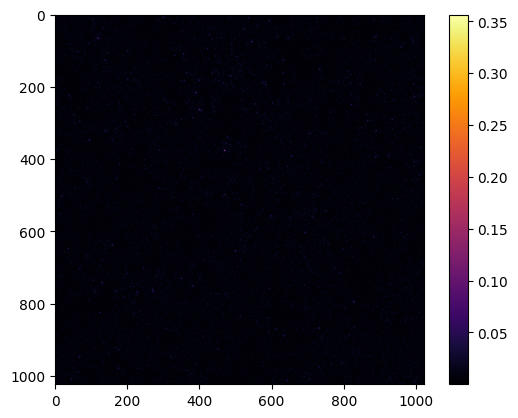

In [83]:
plt.imshow(pw_diff, cmap='inferno')
plt.colorbar()
plt.show()

In [53]:
def Gaussian_smoothing(kappa:np.ndarray,n:int,theta:float,epsilon=25) -> np.ndarray:
    """Applies Gaussian smoothing to a convergence map.

    This is done by taking Fourier transform of the convergence map, and a Gaussian,
    convolving them, and then applying an inverse Fourier transform to the result.

    Args:
        kappa (np.ndarray): Convergence map.
        n (int): The dimensions, in pixels, of a square map kappa, where n x n is the no. of pixels in kappa.
        theta (float): Opening angle in deg.
        epsilon (int): Smoothing scale.

    Returns:
        smoothed_kappa (np.ndarray): Returns a smoothed representation of the the convergence field.
    """
    kappa_f = np.fft.fft2(kappa) #Fourier transform of kappa
    kappa_f_shifted = np.fft.fftshift(kappa_f) #Changes the indexing of the Fourier coefficients
    
    Gaussian_filter = np.zeros((n,n))
    i = (epsilon*n)/(60*theta)
    sig_pix = i/(2*np.sqrt(2*np.log(2)))

    t = int(n/2)
    y = np.arange(-t,t)
    xx,yy = np.meshgrid(y,y)

    exponential = np.exp(-(xx**2 + yy**2)*2*(sig_pix*np.pi)**2)
    Gaussian_filter = exponential

    smoothed_kappa_f = np.fft.ifftshift(kappa_f_shifted*Gaussian_filter)
    smoothed_kappa = np.fft.ifft2(smoothed_kappa_f)
    return smoothed_kappa

In [54]:
manual_kappa = Gaussian_smoothing(gt, 1024, 5.0)

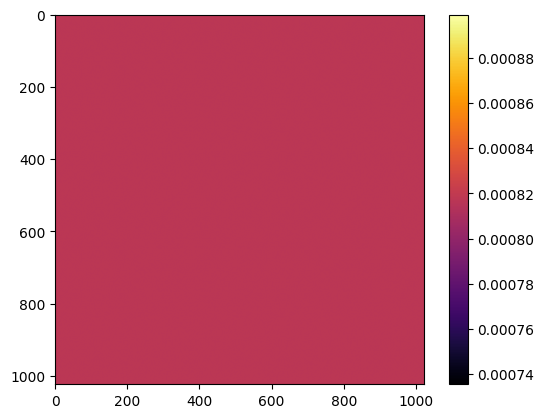

In [56]:
plt.imshow(manual_kappa.real, cmap='inferno')
plt.colorbar()
plt.show()